In [74]:
import re
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import os
import nltk
from langdetect import detect 
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt

**Practice 6**

In [2]:
pd.set_option('display.max_colwidth', 500)

# Word2Vec UK

In [3]:
# en_vectors_file = 'word_vectors/numberbatch-en.txt'
uk_vectors_file = 'word_vectors/news.lowercased.tokenized.word2vec.300d'

uk_vectors = KeyedVectors.load_word2vec_format(uk_vectors_file, binary=False)

In [4]:
ik_vectors = uk_vectors.get_vector('слово')
uk_vectors.most_similar('слово', topn=3)

[('дієслово', 0.6502863764762878),
 ('слівце', 0.6484909653663635),
 ('словосполучення', 0.6456568241119385)]

In [5]:
uk_vectors.similar_by_vector(uk_vectors.get_vector('король')\
                             - uk_vectors.get_vector('чоловік')\
                             + uk_vectors.get_vector('жінка'))

[('королева', 0.6083585023880005),
 ('дама', 0.5521167516708374),
 ('принцеса', 0.5491374135017395),
 ('знаменитість', 0.544516921043396),
 ('жінка', 0.5441810488700867),
 ('танцівниця', 0.5311182737350464),
 ('панянка', 0.5286627411842346),
 ('кінозірка', 0.5274341106414795),
 ('актриса', 0.52556973695755),
 ('матуся', 0.525367021560669)]

In [6]:
uk_vectors.most_similar(positive=['король', 'жінка'], negative=['чоловік'])

[('королева', 0.6513357162475586),
 ('принцеса', 0.5810298323631287),
 ('дама', 0.559023916721344),
 ('танцівниця', 0.5500212907791138),
 ('кінозірка', 0.544483482837677),
 ('знаменитість', 0.5426367521286011),
 ('матуся', 0.5346686840057373),
 ('красуня', 0.5342152714729309),
 ('дівчина', 0.5334903597831726),
 ('імператриця', 0.5316277742385864)]

In [ ]:
def get_files(directory_path):
    '''Read all files in the given directory to a dataframe'''
    data = []

    for filename in os.listdir(directory_path):
        with open(os.path.join(directory_path, filename)) as f:
            docs = f.read().split('\n\n')
            for doc in docs:
                data.append((filename[:len(filename)-4], doc))

    return pd.DataFrame(data, columns=['category', 'text'])



In [7]:
def get_files(directory_path):
    '''Read all files in the given directory to a dataframe'''
    data = []

    for filename in os.listdir(directory_path):
        with open(os.path.join(directory_path, filename)) as f:
            docs = re.split(r'\n{2,4}', f.read())
            # docs = f.read().split('\n\n')
            for doc in docs:
                if doc.isdigit():
                    continue
                try:
                    language = detect(doc)
                except:
                    continue
                if doc.strip('\n'):
                    data.append((filename[:len(filename)-4], doc))

    return pd.DataFrame(data, columns=['category', 'text'])

In [8]:
data_path = 'data/1551/'
df_data = get_files(data_path)

In [10]:
# df_data.to_pickle('df_ukr')

In [ ]:
# pd.read_pickle('df_ukr')

In [11]:
df_data = df_data[df_data['text'].map(lambda x: len(x.split())) > 3] 
df_data.head(4)

,category,text
0,Розрахунки--нарахування-та-перерахунок-субсидій,"3096223\nХочу Вас спитати, маю я право на субсидію чи ні!\nВ квартирі прописані я та дочка. Батько наш помер у 2014. Він мав інваліда війни 3 групи.Пільги як вдова померлого я оформила. В нас трикімнатна крартира. Кожен місяць рахунки більші за мою пенсію.Дочка навчається. Доходів крім моєї пенсії немає.\n"
1,Розрахунки--нарахування-та-перерахунок-субсидій,"з повагою, Гончаренко Олена Віталіївна\nконт.273-56-71; 096-118-49-88; 099-143-30-12"
2,Розрахунки--нарахування-та-перерахунок-субсидій,"3401866\nДобрый день, подскажите как оформить субсидию на электричество, подавал заявку на оформление, пришла субсидия на воду и квартплату. На электричество нет."
3,Розрахунки--нарахування-та-перерахунок-субсидій,"3382672\nПри подаче декларации и заявления на субсидию в Собес Дарницкого района Харьковское шоссе, 176-г, 28.09.15 в принятии заявления и декларации было отказано, по причине отсутствия справки о доходах за последние 3 месяца, хотя в перечни документов на субсидию она не числится.Во второй раз при подаче уже со справкой не приняли опять, в связи с не правильными месяцами в справке хотя в декларации было указаны сроки с 01.07 по 30.09 и справка подавалась за эти же сроки.На вопрос почему н..."


In [ ]:
# Беремо категорії, яких хоча б 50 записів

# cat_sr = df_data['category'].value_counts()
# cat_list = list(cat_sr[cat_sr  >= 50].index)
# df_data = df_data[df_data['category'].isin(cat_list)] 

In [13]:
# df_data['text'].map(lambda x: detect(x)).value_counts()

In [14]:
def getTextVect(text):
    tokens = nltk.word_tokenize(text)
    vectors = np.array([uk_vectors.get_vector(i.lower()) for i in tokens if i.lower() in uk_vectors.vocab])    
    return np.sum(vectors, axis=0)/len(vectors)

In [15]:
df_data['docVec'] = df_data['text'].map(getTextVect)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [16]:
df_data.head()

,category,text,docVec
0,Розрахунки--нарахування-та-перерахунок-субсидій,"3096223\nХочу Вас спитати, маю я право на субсидію чи ні!\nВ квартирі прописані я та дочка. Батько наш помер у 2014. Він мав інваліда війни 3 групи.Пільги як вдова померлого я оформила. В нас трикімнатна крартира. Кожен місяць рахунки більші за мою пенсію.Дочка навчається. Доходів крім моєї пенсії немає.\n","[-1.1466045, 0.042622652, -0.331657, -0.55121243, 0.27422687, 0.39241314, 0.18087508, -0.13655546, -0.31832933, -0.21742259, 0.10772004, -1.3775011, -0.015786614, -0.4681215, 1.074936, 0.26428825, 0.19251128, 0.5258238, 0.111367285, -0.0033100985, -0.17411625, -0.2771207, 0.40407512, 0.13882384, -0.66843086, 0.17900658, -0.73340523, 0.09891017, -0.44468954, 0.086618304, -0.41374683, -0.19567637, 0.098577954, -0.15452564, 0.5831375, 0.26284486, 0.031096002, -0.24507056, -0.21092543, 0.2472035..."
1,Розрахунки--нарахування-та-перерахунок-субсидій,"з повагою, Гончаренко Олена Віталіївна\nконт.273-56-71; 096-118-49-88; 099-143-30-12","[0.20870619, -0.9677464, -0.7642809, -0.290998, -0.13014263, -0.013973397, -1.0770098, 0.26991582, 0.14363122, -0.18232499, -0.04674138, -0.6400675, -0.6446908, 0.123845614, 1.4246522, 0.1845884, 0.005487001, 0.3681524, 0.1874194, -0.3298048, -0.14044197, 1.1567986, -0.30318636, -0.30110416, 0.11305182, 0.1454632, 0.92931956, -0.25293177, -0.5039086, 0.06342183, 0.98153675, -0.89151555, -0.47548604, -0.070341006, 0.371012, 0.49356598, 0.0715708, -0.0691224, 0.1938556, -0.7131834, 0.09169383,..."
2,Розрахунки--нарахування-та-перерахунок-субсидій,"3401866\nДобрый день, подскажите как оформить субсидию на электричество, подавал заявку на оформление, пришла субсидия на воду и квартплату. На электричество нет.","[-1.3424722, 0.012133461, -0.3186596, 0.1902342, 0.23378223, 0.22873966, -0.44749394, 0.55153745, -0.21608986, 0.88379073, 0.217737, -0.60196096, -0.013013596, -0.36241177, 0.74362, -0.12555303, 0.12862279, -0.8686416, -0.14267606, 0.6483928, 0.2918035, -0.13451594, -0.57774156, -0.1745874, -0.39682344, -0.008897892, -0.01963741, 0.8528492, -0.8379301, -0.13484474, 0.2842572, -0.3385751, 0.94113797, -0.49993765, 0.6076266, 1.0614895, -0.06700967, 0.39811662, -0.43333212, 1.0354766, -0.243083..."
3,Розрахунки--нарахування-та-перерахунок-субсидій,"3382672\nПри подаче декларации и заявления на субсидию в Собес Дарницкого района Харьковское шоссе, 176-г, 28.09.15 в принятии заявления и декларации было отказано, по причине отсутствия справки о доходах за последние 3 месяца, хотя в перечни документов на субсидию она не числится.Во второй раз при подаче уже со справкой не приняли опять, в связи с не правильными месяцами в справке хотя в декларации было указаны сроки с 01.07 по 30.09 и справка подавалась за эти же сроки.На вопрос почему н...","[-0.42339197, 0.022349417, 0.090464, -0.5342938, 0.14928286, 0.1292041, -0.5196757, 0.49986443, -0.31630728, -0.09232312, -0.054086532, -0.7147041, -0.12327906, -0.32942888, 0.5166025, -0.23134682, 0.02954633, 0.08782276, 0.10330051, -0.110190496, -0.34711927, -0.1633629, 0.11923215, -0.014161969, 0.07002268, 0.04112229, -0.24170794, 0.28336987, -0.54672575, 0.10947205, -0.08333993, -0.014442541, 0.28003013, -0.14117081, 0.3537478, 0.3995851, 0.003561765, -0.18839234, -0.2789959, 1.0219988, ..."
4,Розрахунки--нарахування-та-перерахунок-субсидій,"3354708\nПитання про надання субсидій. Чому ходять чутки, що при продажі квартири, на яку було оформлено субсидію, з власника квартири буде стягнуто всю суму нарахованої субсидії за весь час отримання субсидії? Чому про це ніде не повідомляється? Прошу надати вичерпну відповідь.","[-1.0352076, 0.22297935, -0.40898973, -0.6076635, 0.10479085, 0.78215086, 0.46404165, -0.4445885, -0.43652838, -0.3316872, 0.06801542, -1.1920534, -0.30191672, -0.29124352, 0.4586749, -0.44025865, 0.14361024, -0.44541317, -0.17907095, -0.350579, -0.4999219, -0.1466873, 0.21561205, -0.20994136, -0.61569315, -0.17225562, -0.90938294, -0.04753293, -0.7709505, -0.011216705, -0

In [17]:
df_data = df_data[df_data['docVec'].map(lambda x: not(np.isnan(x).any()))].reset_index(drop=True)

# Cosine similarity example
The resulting similarity ranges from −1 meaning exactly opposite, to 1 meaning exactly the same, with 0 indicating orthogonality or decorrelation, while in-between values indicate intermediate similarity or dissimilarity.

In [36]:
df_data['text'].iloc[0]

'3096223\nХочу Вас спитати, маю я право на субсидію чи ні!\nВ квартирі прописані я та дочка. Батько наш помер у 2014. Він мав інваліда війни 3 групи.Пільги як вдова померлого я оформила. В нас трикімнатна крартира. Кожен місяць рахунки більші за мою пенсію.Дочка навчається. Доходів крім моєї пенсії немає.\n  '

In [37]:
df_data['text'].iloc[5]

'3350015\nЦього року я подала поштою необхідні документи (заяву, декларацію) для призначення субсидії на послуги ЖКГ до управління соцзахитсу населення Дніпровської РДА м.Києва. На сьогоднішній день відповіді про призначення субсидії чи відмову в призначенні не отримала, незважаючи на те, що передбачені законодавством строки вже давно минули. Зараз мені знову прийшли бланки заяви та декларації для призначення субсидії. Однак, я не знаю - чи надана мені вже субсидія чи ні.'

In [18]:
# For example
cosine_similarity(df_data['docVec'].iloc[0].reshape(1,300), df_data['docVec'].iloc[5].reshape(1,300))

array([[0.62601674]], dtype=float32)

In [33]:
def getMostSimilarText(row):
    score_with_index = [(cosine_similarity(
                            row['docVec'].reshape(1,-1),\
                            i.reshape(1,-1)),
                       j)\
          for i, j in zip(list(df_data['docVec']), list(df_data.index)) \
        if not(np.array_equal(i, row['docVec']))]
                        
    max_value = np.array([i for i, j in score_with_index]).max()
    max_index = [j for i, j in score_with_index if i == max_value][0]
    most_similar_text = df_data.iloc[max_index]['text']
    return max_value, most_similar_text  
       

In [34]:
df_data[:1]

,category,text,docVec
0,Розрахунки--нарахування-та-перерахунок-субсидій,"3096223\nХочу Вас спитати, маю я право на субсидію чи ні!\nВ квартирі прописані я та дочка. Батько наш помер у 2014. Він мав інваліда війни 3 групи.Пільги як вдова померлого я оформила. В нас трикімнатна крартира. Кожен місяць рахунки більші за мою пенсію.Дочка навчається. Доходів крім моєї пенсії немає.\n","[-1.1466045, 0.042622652, -0.331657, -0.55121243, 0.27422687, 0.39241314, 0.18087508, -0.13655546, -0.31832933, -0.21742259, 0.10772004, -1.3775011, -0.015786614, -0.4681215, 1.074936, 0.26428825, 0.19251128, 0.5258238, 0.111367285, -0.0033100985, -0.17411625, -0.2771207, 0.40407512, 0.13882384, -0.66843086, 0.17900658, -0.73340523, 0.09891017, -0.44468954, 0.086618304, -0.41374683, -0.19567637, 0.098577954, -0.15452564, 0.5831375, 0.26284486, 0.031096002, -0.24507056, -0.21092543, 0.2472035..."


In [35]:
# df_data['mostSimText'] = 
df_data[:1].apply(lambda x: getMostSimilarText(x), axis=1)

0    (0.8624572, 3093082\nЯк можна отримати субсидію на комунальні послуги в моєму випадку?\nЯ проживаю в квартирі з неповнолітнім сином.  Право власності на квартиру маємо кожен по 1/3: я, мій неповнолітній син, мій колишній чоловік. З чоловіком розлучена і він з нами не проживає (має іншу сімю). \nМій єдиний дохід (працюю в комерційній фірмі) складає 1400 грн.\nЗаздалегідь вдячна!)
dtype: object

# KNN Classifier

In [ ]:
# le = preprocessing.LabelEncoder()
# le.fit(df_data['category'])
# df_data['label'] = le.transform(df_data['category'])

In [ ]:
df_data

In [121]:
X, y = df_data['docVec'], df_data['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # test_size=0.33

In [29]:
neigh = KNeighborsClassifier(n_neighbors=3) #, metric=cosine

In [30]:
neigh.fit(list(X_train), y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

# Evaluation

In [31]:
predicted = neigh.predict(list(X_test))

In [32]:
print(classification_report(y_true=y_test, y_pred=predicted))

                                                                                  precision    recall  f1-score   support

                                                                     Інші-Подяки       0.14      0.16      0.15       207
                                              Інші-технічні-недоліки-стану-ліфту       0.11      0.35      0.17       636
                Аварійний--травмонебезпечний-стан-утримання-об-єктів-благоустрою       0.08      0.14      0.10       222
                                          Бажаючі-отримати--Картки-киянина--КК--       0.17      0.27      0.21        44
                              Будівництво--дооблаштування-спортивних-майданчиків       0.05      0.13      0.08        71
                                                                 Будівництво-АЗС       0.07      0.20      0.10        51
                                                        Будівництво-в-нічний-час       0.05      0.15      0.08        55
                       

# Результати

# KNN Classifier with cosine similarity 
Використовую cosine similarity метрику для KNN <br>

На всіх даних метод predict KNN з cosine similarity працює дуже довго, тому зменшимо кількість даних, при цьомк потрібно, щоб у нову зменшену вибірку оптрапили всі класи та кількості прикладів на клас були менш-більш однакові. Враховуючи, що класи незбалансовані, то використовую under-sampling. <br>

Для **under-sampling** використаємо **Prototype generation**. Візьмемо метод кластеризації **K-means** для зменшення кількості зразків. Тому, кожен клас буде представлений як центроїди з K-means замість первинних зразків.  

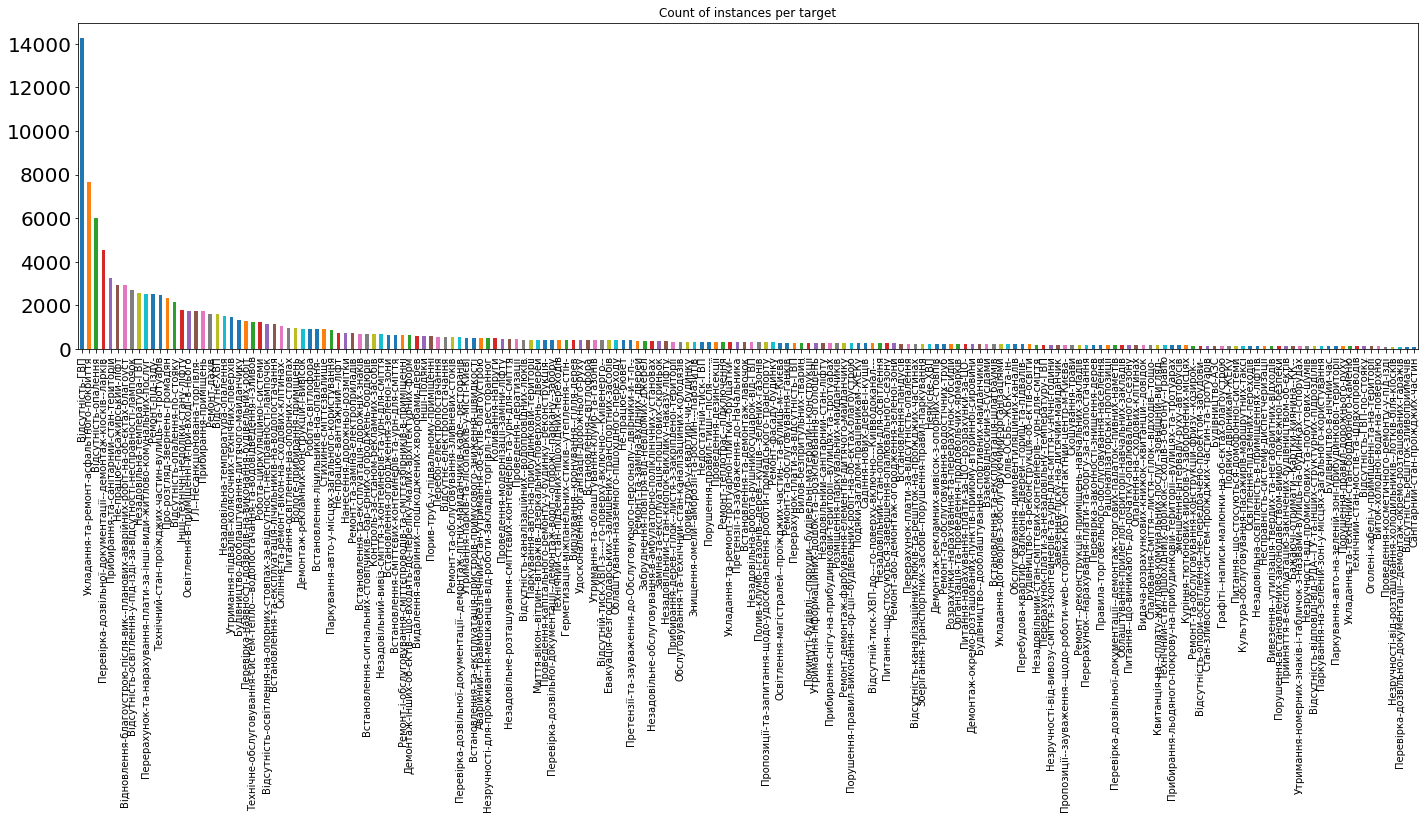

In [120]:
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=20)  
y_train.value_counts().plot(kind='bar', title='Count of instances per target', figsize=(24,6))


In [108]:
from imblearn.under_sampling import ClusterCentroids

In [109]:
cc = ClusterCentroids(random_state=0)

In [122]:
X, y = df_data['docVec'], df_data['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) # test_size=0.33

In [123]:
X_resampled, y_resampled = cc.fit_resample(np.stack(np.array(X_train)), y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (106) found smaller than n_clusters (108). Possibly due to duplicate points in X.
  return_n_iter=True)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (105) found smaller than n_clusters (108). Possibly due to duplicate points in X.
  return_n_iter=True)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (103) found smaller than n_clusters (108). Possibly due to duplicate points in X.
  return_n_iter=True)


In [124]:
pd.Series(y_resampled).value_counts()

Ремонт--реконструкція-приміщень-навчальних-закладів                                 108
Ремонт-та-обслуговування-зливневих-стоків                                           108
Облаштування-наземного-пішохідного-переходу                                         108
Порушення-встановлених-законодавством-вимог-пожежної-безпеки                        108
Встановлення-та-експлуатація-дорожніх-знаків                                        108
Прибирання-приміщень                                                                108
Розрахунки--нарахування-та-перерахунок-субсидій                                     108
Завезення-піску-на-дитячий-майданчик                                                108
Проведення-модернізації-заміни-ліфту                                                108
Питання-нарахування-плати-за-ЦО--розрахунки-за-ЦО-                                  108
Незадовільний-стан-кнопок-виклику-наказу-ліфту                                      108
Незадовільний-стан-сміттєвих-кон

In [125]:
from scipy.spatial.distance import cosine

In [126]:
neigh_cos = KNeighborsClassifier(n_neighbors=3, metric=cosine)

In [127]:
neigh_cos.fit(X_resampled, y_resampled) 

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function cosine at 0xb12f5f510>, metric_params=None,
           n_jobs=None, n_neighbors=3, p=2, weights='uniform')

In [128]:
predicted_cos = neigh_cos.predict(list(X_test))

In [129]:
print(classification_report(y_true=y_test, y_pred=predicted_cos))

                                                                                  precision    recall  f1-score   support

                                                                     Інші-Подяки       0.15      0.34      0.21        68
                                              Інші-технічні-недоліки-стану-ліфту       0.12      0.29      0.17       213
                Аварійний--травмонебезпечний-стан-утримання-об-єктів-благоустрою       0.04      0.16      0.06        68
                                          Бажаючі-отримати--Картки-киянина--КК--       0.15      0.60      0.24        15
                              Будівництво--дооблаштування-спортивних-майданчиків       0.02      0.10      0.03        21
                                                                 Будівництво-АЗС       0.04      0.15      0.06        13
                                                        Будівництво-в-нічний-час       0.05      0.23      0.08        22
                       